# 

In [13]:
import os
import random
import numpy as np
import tensorflow as tf

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [14]:
# GPU 설정
gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
IMG_SIZE=86
BATCH_SIZE=32
DATA_PATH="../../data/processed/02_kaggle_dataset/train"

datagen=ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.7, 1.3],
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    horizontal_flip=False,
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

input_shape = (IMG_SIZE, IMG_SIZE, 3)
base_model = ResNet50V2(include_top=False, weights="imagenet", input_shape=input_shape)
base_model.trainable = True

inputs = Input(shape=input_shape)
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [17]:
# Dropout 증가 + L2 + Dense 노드 축소
# model=Sequential([
#     Conv2D(64, 3, activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 1)),
#     BatchNormalization(),
#     MaxPooling2D(2),

#     Conv2D(96, 3, activation="relu"),
#     BatchNormalization(),
#     MaxPooling2D(2),

#     Flatten(),
#     Dense(32, activation="relu", kernel_regularizer=l2(0.001)),  # Dense 노드 축소 + 정규화
#     Dropout(0.4),  # Dropout 증가
#     Dense(1, activation="sigmoid")
# ])

# model.compile(optimizer=Adam(learning_rate=0.0005),
#             loss="binary_crossentropy", metrics=["accuracy"])

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. 검증 성능이 나빠지면 학습 중단 (val_loss 기준)
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

# 2. 검증 성능 개선이 없으면 학습률 자동으로 줄이기
lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # 학습률을 절반으로 줄임
    patience=2,       # 2 epoch 동안 개선 없을 때 발동
    min_lr=1e-7,      # 최소 학습률 설정
    verbose=1
)

In [19]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, lr_schedule],
    class_weight={0: 1.8, 1: 1.0}  # 필요 시 recall 보완
)

Epoch 1/20
1200/1200 [==============================] - 75s 60ms/step - loss: 0.4566 - accuracy: 0.8549 - val_loss: 1.5422 - val_accuracy: 0.5356 - lr: 1.0000e-05
Epoch 2/20
1200/1200 [==============================] - 71s 59ms/step - loss: 0.1038 - accuracy: 0.9740 - val_loss: 2.1509 - val_accuracy: 0.5410 - lr: 1.0000e-05
Epoch 3/20
1200/1200 [==============================] - ETA: 0s - loss: 0.0537 - accuracy: 0.9870  
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
1200/1200 [==============================] - 71s 59ms/step - loss: 0.0537 - accuracy: 0.9870 - val_loss: 2.6752 - val_accuracy: 0.5471 - lr: 1.0000e-05
Epoch 4/20
Restoring model weights from the end of the best epoch: 1.s: 0.0360 - accuracy: 0.9919  
1200/1200 [==============================] - 71s 59ms/step - loss: 0.0360 - accuracy: 0.9919 - val_loss: 2.8653 - val_accuracy: 0.5584 - lr: 5.0000e-06
Epoch 4: early stopping


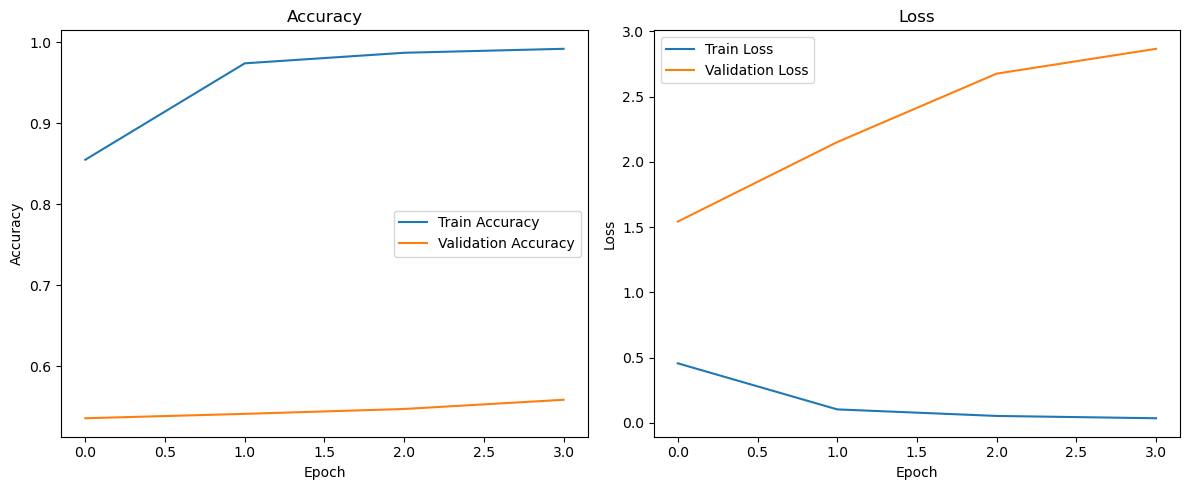

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("../../results/images/02_readjusted_training_plot.png")
plt.show()

              precision    recall  f1-score   support

      closed       0.53      0.57      0.55      4800
        open       0.54      0.49      0.51      4800

    accuracy                           0.53      9600
   macro avg       0.53      0.53      0.53      9600
weighted avg       0.53      0.53      0.53      9600



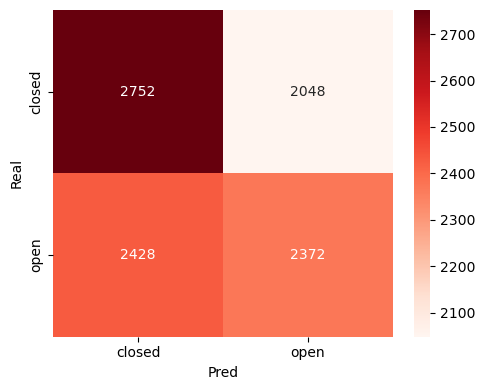

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

# classification report
report=classification_report(y_true, y_pred, target_names=["closed", "open"])
print(report)
with open("../../results/reports/02_resnet_classification_report.txt", "w") as f:
    f.write(report)

# confusion matrix
conf_matirx=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matirx, annot=True, fmt="d", cmap="Reds",
            xticklabels=["closed", "open"], yticklabels=["closed", "open"])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("../../results/images/02_resnet_confusion_matrix.png")
plt.show()

In [22]:
os.makedirs("../../src/models/09_02ResNet_Model", exist_ok=True)
model.save("../../src/models/09_02ResNet_Model/readjusted_model.keras")